# Synopsis

This code generates the g2 and tau vs. Q figure (droplet) for the manuscript

## Initialize

In [1]:
import numpy as np
from numpy import sqrt, sin, cos, pi, exp
import csv
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import h5py  

from scipy.optimize import curve_fit
import scipy.integrate as integrate
from xpcs_viewer import XpcsFile as xf


## Read hdf XPCS results into python objects

In [2]:
fn_path = "../Data/"
noisy_droplet = "E0098_D100_Pendant_022C_att01_Rq0_00001_0001-100000.hdf"
dropleta = "AvgF084_Pendant_WithCase_Cen_att00_Lq0_Rq0_00001_0001-100000.hdf"
CapCellb = "AvgD129_D100_samy3_Cell_att00_Lq0_Rq0_00001_0001-100000.hdf"
capillaryc = "AvgF091_D100_Capillary_Post_att00_Lq0_Rq0_00001_0001-100000.hdf"
 
droplet = xf(dropleta, cwd = fn_path)
CapCell = xf(CapCellb, cwd = fn_path)
capillary = xf(capillaryc, cwd = fn_path)

tmp_x = []
tmp_y = []
tmp_z = []
with open("../Data/Burst_Mode_Analysis/burst_plot.csv", "r") as File:  
    plots = csv.reader(File,  delimiter = ',') 
    count = 0
    for row in plots:
        
        if count > 9:
            break
        tmp_x.append(float(row[0]))
        tmp_y.append(float(row[2]))
        tmp_z.append(float(row[1]))
        count+=1

burst_x = np.array(tmp_x)
burst_y = np.array(tmp_y)
burst_z = np.array(tmp_z)


## Extract and fit g2

In [3]:
contrast = 0.185
contrast_droplet = 0.185
contrast_cell = 0.17
contrast_cap = 0.18
contrast_noisy_drop = 0.172
exp_arg = 1

LB_list_g2 = [contrast, 1e-6, exp_arg, 0.95]
UB_list_g2 = [contrast, 1, exp_arg, 1.05]

a = droplet.fit_g2(q_range=[1, 1.75],t_range=[1e-7, 8e-2], bounds=[LB_list_g2, UB_list_g2],
    fit_flag=[False, True, False, True])
b = CapCell.fit_g2(q_range=[1, 1.75],t_range=[1e-7, 8e-2], bounds=[[contrast_cell, 1e-6, exp_arg, 0.95],[contrast_cell, 1, exp_arg, 1.05]],
    fit_flag=[False, True, False, True])
c = capillary.fit_g2(q_range=[1, 1.75],t_range=[1e-7, 8e-2], bounds=[[contrast_cap, 1e-6, exp_arg, 0.95],[contrast_cap, 1, exp_arg, 1.05]],
    fit_flag=[False, True, False, True])    

g2_fit_line_droplet = a["fit_line"]
g2_fit_line_CapCell = b["fit_line"]
g2_fit_line_capillary = c["fit_line"]

g2_fit_coeff_droplet = a["fit_val"]
g2_fit_coeff_CapCell = b["fit_val"]
g2_fit_coeff_capillary = c["fit_val"]

tauq_power = -2
LB_list_tauQ = [1e-12, tauq_power]
UB_list_tauQ = [1e-3, tauq_power]

a= droplet.fit_tauq(q_range=[0, 0.01], bounds=[LB_list_tauQ, UB_list_tauQ], fit_flag=[True, False])
tauq_fit_val_droplet = a["tauq_fit_val"]
tauq_fit_line_droplet = a["tauq_fit_line"]
tauq_q_droplet = a["tauq_q"]
tauq_tau_droplet = a["tauq_tau"]
tauq_tau_err_droplet = a["tauq_tau_err"]

b = CapCell.fit_tauq(q_range=[0, 0.01], bounds=[LB_list_tauQ, UB_list_tauQ], fit_flag=[True, False])
tauq_fit_val_CapCell = b["tauq_fit_val"]
tauq_fit_line_CapCell = b["tauq_fit_line"]
tauq_q_CapCell = b["tauq_q"]
tauq_tau_CapCell = b["tauq_tau"]
tauq_tau_err_CapCell = b["tauq_tau_err"]

c = capillary.fit_tauq(q_range=[0, 0.01], bounds=[LB_list_tauQ, UB_list_tauQ], fit_flag=[True, False])
tauq_fit_val_capillary = c["tauq_fit_val"]
tauq_fit_line_capillary = c["tauq_fit_line"]
tauq_q_capillary = c["tauq_q"]
tauq_tau_capillary = c["tauq_tau"]
tauq_tau_err_capillary = c["tauq_tau_err"]




## Figure rendering

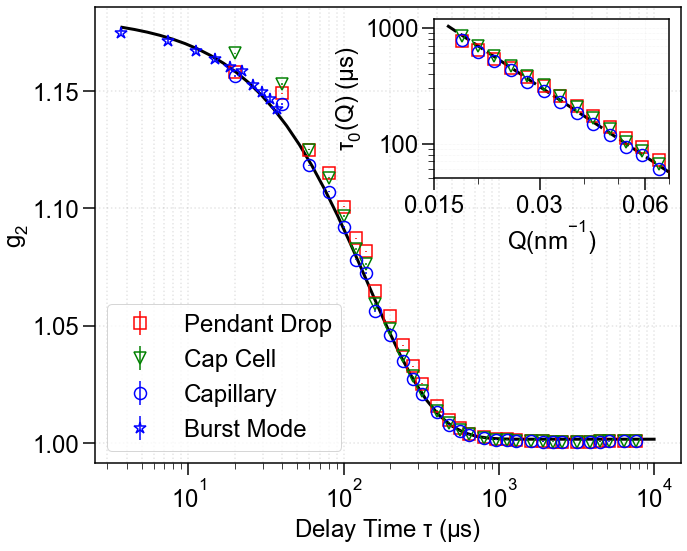

In [5]:

scale = 3
width = 3.5*scale
font_size = 8*scale
line_width = 0.5*scale
marker_size = 4*scale
tick_length_major = 4*scale
tick_length_minor = 2*scale

dim=1

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(width, 0.8*width))
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = line_width
 
a1,b1,c1,d1 = float(c["fit_val"][5,0,0]), float(c["fit_val"][5,0,1]), float(c["fit_val"][5,0,2]), float(c["fit_val"][5,0,3])
a1,b1,c1,d1 = float(c["fit_val"][5,0,0]), float(c["fit_val"][5,0,1]), float(c["fit_val"][5,0,2]), float(c["fit_val"][5,0,3])
xl = np.logspace(-6, -2, num=50, endpoint=True, base=10.0, dtype=np.longfloat, axis=0)
j = (xl/b1)**c1
y1 = (a1 * exp(-2 * j)) + d1

ax.errorbar(1e6*droplet.t_el[0:30], (droplet.g2[:,5][0:30]), yerr=(droplet.g2_err[:,5][0:30]), fmt='rs', label = 'Pendant Drop', markersize = marker_size, linewidth = line_width, markeredgewidth = line_width, markerfacecolor='none')
ax.plot(1e6*xl[7:50], y1[7:50], 'k-', markersize=marker_size, linewidth = 2*line_width)
ax.errorbar(1e6*CapCell.t_el[0:30], (CapCell.g2[:,5][0:30]), yerr=(CapCell.g2_err[:,5][0:30]), fmt='gv',label = 'Cap Cell', markersize = marker_size, linewidth = line_width, markeredgewidth = line_width, markerfacecolor='none')
ax.errorbar(1e6*capillary.t_el[0:30], (capillary.g2[:,5][0:30]), yerr=(CapCell.g2_err[:,5][0:30]), fmt='bo', label = 'Capillary', markersize = marker_size, linewidth = line_width, markeredgewidth = line_width, markerfacecolor='none')

ax.errorbar(1e6*burst_x, burst_z, yerr = burst_y, color = 'b', fmt='*', label = 'Burst Mode', markersize = marker_size, linewidth = line_width, markeredgewidth = line_width, markerfacecolor='none')

ax.legend(loc='lower left', prop={'size': font_size})

ax.grid(color='k', linestyle=':', linewidth=line_width, alpha=0.1, which='both')
ax.tick_params('both', length=tick_length_major, width=line_width, which='major', labelsize=font_size)
ax.tick_params('x', length=tick_length_minor, width=0.5*line_width, which='minor',
              labelleft=False, labelbottom=False)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(line_width)

ax.set_ylabel('g$\mathdefault{_2}$', 
              fontsize=font_size, labelpad=0.05*font_size)
ax.set_yticks([1.0, 1.05, 1.1, 1.15])

ax.set_xscale('log')

ax.set_xlabel('Delay Time $\mathdefault{\u03C4}$ ($\mathdefault{\mu}$s)', 
              fontsize=font_size, labelpad=0.2*font_size)

axins = inset_axes(ax, width="40%", height="35%", loc=1, borderpad=0.05*font_size)
axins.errorbar(tauq_q_droplet*10,tauq_tau_droplet*1e6,tauq_tau_err_droplet,fmt='rs',markeredgewidth = line_width,
               linewidth=line_width, markersize=marker_size,  markerfacecolor='none')
axins.errorbar(tauq_q_CapCell*10,tauq_tau_CapCell*1e6,tauq_tau_err_CapCell,fmt='gv',markeredgewidth = line_width,
               linewidth=line_width, markersize=marker_size,  markerfacecolor='none')
axins.errorbar(tauq_q_capillary*10,tauq_tau_capillary*1e6,tauq_tau_err_capillary,fmt='bo',markeredgewidth = line_width,
               linewidth=line_width, markersize=marker_size,  markerfacecolor='none')
axins.plot(tauq_fit_line_droplet["fit_x"]*10,tauq_fit_line_droplet["fit_y"]*1e6,'k--',linewidth=2*line_width)

for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(line_width)

axins.set_xscale('log')
axins.set_xlim(1.8e-2, 7e-2)
axins.set_xticks([1.5e-2, 3e-2, 6e-2])
axins.set_xticklabels(['0.015',
                    '0.03',
                    '0.06'],
                    fontsize = font_size)

axins.set_xlabel('Q(nm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size )

axins.set_yscale('log')
axins.set_yticks([100, 1000])

axins.set_yticklabels(['100','1000'],fontsize = font_size)
axins.tick_params('both', length=tick_length_major, width=line_width, which='major', labelsize=font_size)
axins.tick_params('both', length=tick_length_minor, width=0.5*line_width, which='minor', 
               labelleft=False, labelbottom=False)
axins.set_ylim(50, 1200)
axins.set_ylabel('$\mathdefault{\u03C4_0}$(Q) ($\mathdefault{\mu}$s)', 
              fontsize=font_size, labelpad=0.05*font_size)



axins.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.1, which='both')

plt.savefig('../Figures/g2_tauQ.pdf', dpi=600, format='pdf', 
            facecolor='w', edgecolor='w', transparent=False, bbox_inches='tight')